In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import skew, norm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu130
CUDA available: True
CUDA version: 13.0
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 5090


In [3]:
# --- 1. Load Data ---
# Assuming 'train.csv' has been downloaded and is in the current working directory.
try:
    df = pd.read_csv('../data/playground-series-s5e10/train.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'train.csv' not found. Please download the file from the Kaggle competition.")

Data loaded successfully.



## 2.1 Data Information (Check Data Types and Missing Values)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_ri

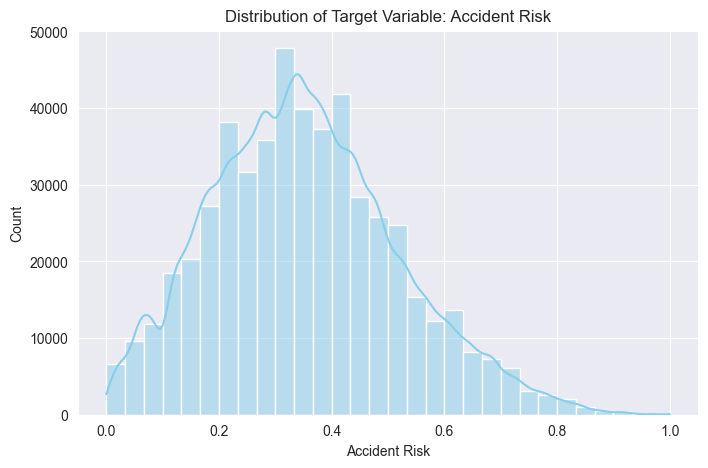

In [4]:
# --- 2. Initial EDA ---
print("\n## 2.1 Data Information (Check Data Types and Missing Values)")
print(df.info())

# Drop the 'id' column as it's typically not a feature
if 'id' in df.columns:
    df = df.drop('id', axis=1)

print("\n## 2.2 Descriptive Statistics (Numerical Features)")
print(df.describe().T)

print("\n## 2.3 Skewness Check (Using Scipy) and Value Counts")
# Identify numerical features (excluding the target for now)
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
if 'accident_risk' in numerical_features:
    numerical_features.remove('accident_risk')

# Calculate skewness for numerical features
skewed_feats = df[numerical_features].apply(lambda x: skew(x.dropna()))
print("Skewness of Numerical Features:\n", skewed_feats)

# Check categorical features
categorical_features = df.select_dtypes(include='object').columns.tolist()
if categorical_features:
    for col in categorical_features:
        print(f"\nValue Counts for '{col}':\n", df[col].value_counts())

# --- 3. Simple Visual EDA (Example) ---
# Check the distribution of the target variable
plt.figure(figsize=(8, 5))
sns.histplot(df['accident_risk'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Target Variable: Accident Risk')
plt.xlabel('Accident Risk')
plt.show()

In [5]:
# --- 1. Separate Features and Target ---
TARGET_COLUMN = 'accident_risk'
X = df.drop(TARGET_COLUMN, axis=1)
y = df[TARGET_COLUMN]

# --- 1.1 Feature Engineering ---
# Create new interaction and ratio features to potentially capture non-linear relationships.

# 1. Accident Rate per Lane (Ratio)
# Represents the concentration of accidents relative to the road capacity.
# Added a small constant (1e-6) to the denominator to prevent division by zero.
df['accident_per_lane'] = df['num_reported_accidents'] / (df['num_lanes'] + 1e-6)

# 2. Curvature-Speed Interaction (Interaction)
# High speed on a high curvature road is likely riskier.
df['curvature_speed_interaction'] = df['curvature'] * df['speed_limit']

# 3. Speed Limit Binning (Discretization)
# Binning the continuous speed_limit feature into categorical groups.
bins = [20, 35, 55, 75] # Defines the bin edges
labels = ['Low Speed', 'Medium Speed', 'High Speed']
df['speed_limit_bin'] = pd.cut(df['speed_limit'], bins=bins, labels=labels, right=True, include_lowest=True)

# 4. Curvature Binning (Discretization)
# Binning the continuous curvature feature into categorical groups.
bins_curv = [0.0, 0.3, 0.7, 1.0] # Define bins for low, medium, and high curvature
labels_curv = ['Low Curvature', 'Medium Curvature', 'High Curvature']
df['curvature_bin'] = pd.cut(df['curvature'], bins=bins_curv, labels=labels_curv, right=True, include_lowest=True)

print("--- 1.1 Feature Engineering Complete ---")
print(f"New features added: accident_per_lane, curvature_speed_interaction")

# --- 2. Identify Column Types ---
# Re-identify features to ensure 'id' is excluded and handle full dataset columns
NUMERICAL_FEATURES = X.select_dtypes(include=np.number).columns.tolist()
CATEGORICAL_FEATURES = X.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical Features: {NUMERICAL_FEATURES}")
print(f"Categorical Features: {CATEGORICAL_FEATURES}")

# --- 3. Create Preprocessing Pipeline (ColumnTransformer) ---
# Define the transformer for numerical features
numerical_transformer = StandardScaler()

# Define the transformer for categorical features
# We set 'sparse_output=False' to get a dense numpy array output
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Create the ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUMERICAL_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough' # Keep any other columns if they exist (not used here)
)

# --- 4. Apply Preprocessing to Features ---
print("\nApplying preprocessing pipeline...")
X_processed_array = preprocessor.fit_transform(X)

# --- 5. Convert back to DataFrame and Combine with Target ---
# Get the names of the encoded categorical features
feature_names = preprocessor.get_feature_names_out()

# Create the processed DataFrame
X_processed = pd.DataFrame(X_processed_array, columns=feature_names)

# Optional: Rename columns to be cleaner (remove the prefix added by ColumnTransformer)
X_processed.columns = [col.split('__')[1] if '__' in col else col for col in X_processed.columns]

# Combine the processed features with the target variable
processed_df = pd.concat([X_processed, y.reset_index(drop=True)], axis=1)

# --- 6. Save the Processed Data ---
OUTPUT_FILE = '../data/processed.csv'
processed_df.to_csv(OUTPUT_FILE, index=False)

print("\n--- Preprocessing Complete ---")
print(f"Processed data shape: {processed_df.shape}")
print(f"First 5 rows of '{OUTPUT_FILE}':")
print(processed_df.head())
print(f"\nFile successfully saved as **{OUTPUT_FILE}**.")

--- 1.1 Feature Engineering Complete ---
New features added: accident_per_lane, curvature_speed_interaction

Numerical Features: ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
Categorical Features: ['road_type', 'lighting', 'weather', 'time_of_day']

Applying preprocessing pipeline...

--- Preprocessing Complete ---
Processed data shape: (517754, 21)
First 5 rows of '../data/processed.csv':
   num_lanes  curvature  speed_limit  num_reported_accidents  \
0  -0.438680  -1.572918    -0.703840               -0.209797   
1   1.346344   1.839137    -0.703840               -1.325918   
2   1.346344   0.518342     1.512963                0.906324   
3   1.346344  -1.536229    -0.703840               -0.209797   
4  -1.331192   0.334898     0.879591               -0.209797   

   road_type_highway  road_type_rural  road_type_urban  lighting_daylight  \
0                0.0              0.0              1.0                1.0   
1                0.0              0.0         


--- 3. Feature Correlation Analysis ---

## Correlation with Target Variable ('accident_risk') ##
accident_risk             1.000
curvature                 0.544
lighting_night            0.466
speed_limit               0.431
num_reported_accidents    0.214
weather_foggy             0.150
holiday                   0.051
weather_rainy             0.036
public_road               0.031
road_type_urban           0.021
time_of_day_evening       0.010
road_signs_present        0.001
school_season            -0.001
time_of_day_afternoon    -0.004
num_lanes                -0.006
time_of_day_morning      -0.006
road_type_rural          -0.010
road_type_highway        -0.011
weather_clear            -0.185
lighting_daylight        -0.215
lighting_dim             -0.233
Name: accident_risk, dtype: float64


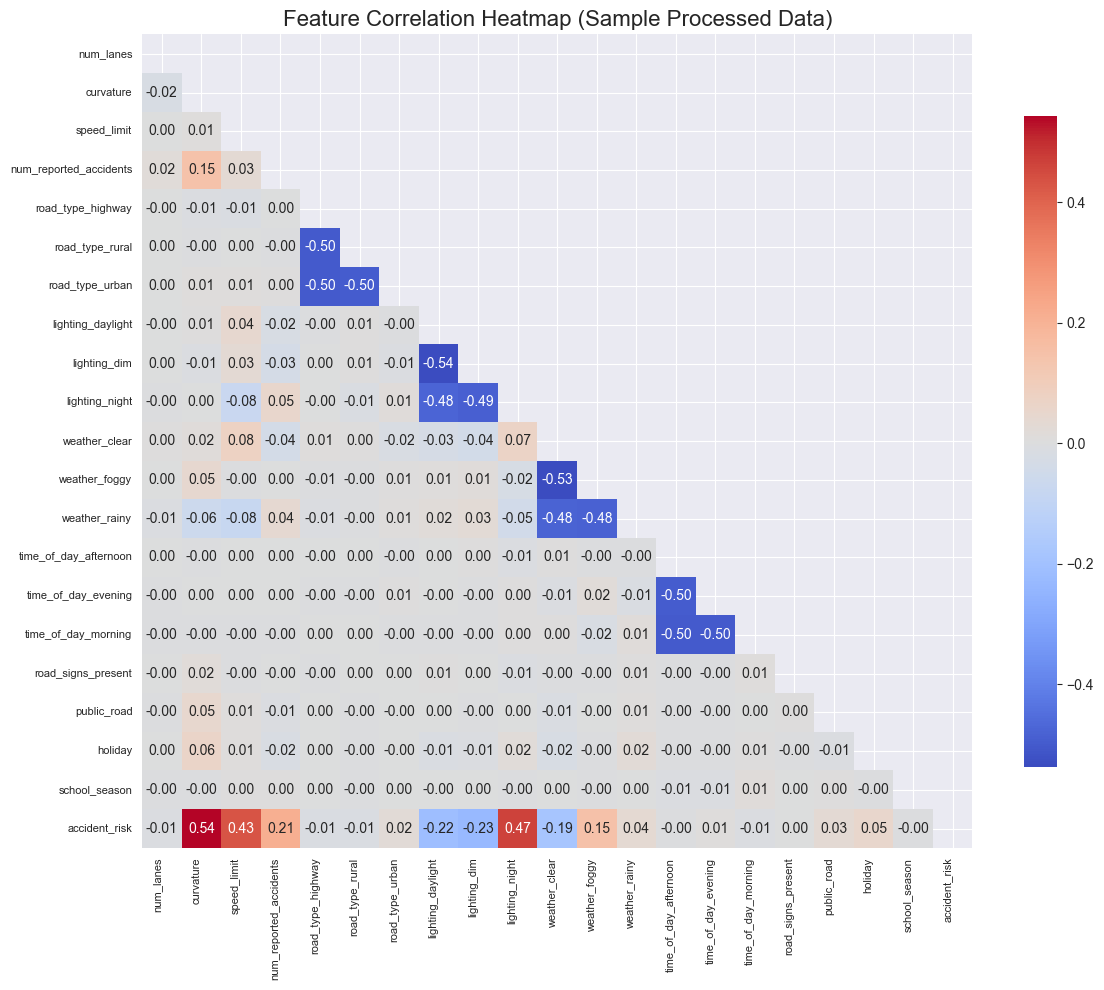

In [6]:
print("\n--- 3. Feature Correlation Analysis ---")

# Calculate Pearson correlation matrix for all columns
correlation_matrix = processed_df.corr()

# Extract correlation with the target variable ('accident_risk')
target_correlation = correlation_matrix['accident_risk'].sort_values(ascending=False)

print("\n## Correlation with Target Variable ('accident_risk') ##")
# Print correlation values, rounding to 3 decimal places
print(target_correlation.round(3))

# Visualize Correlation Matrix (Heatmap)
plt.figure(figsize=(12, 10))

# Create a mask to hide the upper triangle (since the matrix is symmetric)
mask = np.triu(correlation_matrix)

# Generate the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,              # Annotate cells with the correlation value
    fmt=".2f",               # Format the annotation to 2 decimal places
    cmap='coolwarm',         # Use a divergent color map
    mask=mask,               # Apply the mask
    cbar_kws={'shrink': .8}  # Shrink the color bar for better fit
)

plt.title('Feature Correlation Heatmap (Sample Processed Data)', fontsize=16)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show() #

In [7]:
# --- 2.1 Feature Selection: Drop Highly Correlated Features ---

# Define the correlation threshold for dropping features
CORRELATION_THRESHOLD = 0.9

def find_highly_correlated_features(df, threshold):
    """
    Finds one feature from each pair with a correlation above the threshold.
    """
    # Exclude target and ensure only feature columns are used
    df_features = df.drop(TARGET_COLUMN, axis=1)

    # Calculate absolute correlation matrix
    corr_matrix = df_features.corr().abs()

    # Select the upper triangle of the correlation matrix (excluding the diagonal)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = set()
    for column in upper.columns:
        # Find features in the index that are highly correlated with the current column
        highly_correlated_cols = upper.index[upper[column] >= threshold].tolist()
        for feature_to_drop in highly_correlated_cols:
            # Add one of the pair to the drop list
            to_drop.add(feature_to_drop)

    return list(to_drop)

features_to_drop = find_highly_correlated_features(processed_df, CORRELATION_THRESHOLD)

# Create the final, reduced DataFrame
df_reduced = processed_df.drop(columns=features_to_drop, errors='ignore')

print(f"\n--- 2.1 Dropping Highly Correlated Features (Threshold >= {CORRELATION_THRESHOLD}) ---")
print(f"Features dropped: {features_to_drop}")
print(f"Reduced data shape: {df_reduced.shape}")


--- 2.1 Dropping Highly Correlated Features (Threshold >= 0.9) ---
Features dropped: []
Reduced data shape: (517754, 21)


In [8]:
from sklearn.metrics import mean_squared_error

# Final features and target for modeling
X_final = df_reduced.drop(TARGET_COLUMN, axis=1)
y_final = df_reduced[TARGET_COLUMN]

print(f"Data ready for XGBoost modeling. Final feature count: {X_final.shape[1]}")
print(f"Features used: {list(X_final.columns)}")

# --- 3. XGBoost Model Training and Evaluation ---

# Split the data (using a small test size due to limited sample data)
# Setting random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.3, random_state=42
)

# Initialize XGBoost Regressor for GPU training
# NOTE: This requires a CUDA-enabled machine and XGBoost built with GPU support.
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    # Parameters for GPU acceleration
    tree_method='hist',
    device='cuda'
)

print("\nStarting XGBoost training...")

# Train the model
xgb_model.fit(X_train, y_train)

print("Training complete.")

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n--- Model Evaluation Results ---")
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse:.4f}")

Data ready for XGBoost modeling. Final feature count: 20
Features used: ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents', 'road_type_highway', 'road_type_rural', 'road_type_urban', 'lighting_daylight', 'lighting_dim', 'lighting_night', 'weather_clear', 'weather_foggy', 'weather_rainy', 'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning', 'road_signs_present', 'public_road', 'holiday', 'school_season']

Starting XGBoost training...
Training complete.

--- Model Evaluation Results ---
Root Mean Squared Error (RMSE) on Test Set: 0.0570


D:\projects\Predicting-Road-Accident-Risk\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [10:27:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
